# Algoritmo: Agrupamento perfis de velocidades
## Autor: Antônio Claudio Dutra Batista
## Orientador: Francisco Moraes de Oliveria Neto
## Metodologia: Agupamento de perfis de velocidades com consideração do tempo
''' Os dados são de velocidade obtidas pela extração de informações do sistema de localização geografrica de veiculos em operação em um trecho de estudo e para tal situação se deseja identificar os perfis semelhantes (Identificar os grupos existentes) considerando suas velocidades ao longo de uma escala de tempo que tiveram aqueles registros no GPS no espaço de estudo '''

# 1.0 Preparando dados para manipulação

In [1]:
# Trazendo bases com dados de velocidades dos veiculos no trecho em estudo 
import pandas as pd
 
df1 = pd.read_excel('perfil01.xlsx')
df2 = pd.read_excel('perfil02.xlsx')
df3 = pd.read_excel('perfil03.xlsx')
df4 = pd.read_excel('perfil04.xlsx')
# df5 = pd.read_excel()
# df6 = pd.read_excel()
# df7 = pd.read_excel()
# df8 = pd.read_excel()
# df10 = pd.read_excel()

In [2]:
# Concatenando os dataframes
df_concatenado = pd.concat([df1, df2, df3, df4,] , ignore_index=True) # df5, df6, df7, df8, df9, df10], ignore_index=True)

In [3]:
# Se diferencia os veiculos pela coluna id_veiculo 
df_concatenado

,latitude,longitude,id_veiculo,momento,geometry,deltaT,velocidade,geometry_anterior,distancia,distancia_acumulada
0,-3.736013,-38.566300,NaN,2018-11-01 00:00:00,POINT (-38.5663 -3.736013),NaN,NaN,NaN,NaN,NaN
1,-3.735906,-38.565037,32067.0,2018-11-01 09:00:10,POINT (-38.56503677368164 -3.735905885696411),30.0,4.845798,POINT (-38.5663 -3.736013),140.537626,140.537626
2,-3.735875,-38.564865,32067.0,2018-11-01 09:00:40,POINT (-38.56486511230469 -3.735874891281128),30.0,0.641539,POINT (-38.56503677368164 -3.735905885696411),19.246161,159.783787
3,-3.735875,-38.564865,32067.0,2018-11-01 09:01:10,POINT (-38.56486511230469 -3.735874891281128),30.0,0.000000,POINT (-38.56486511230469 -3.735874891281128),0.000000,159.783787
4,-3.735696,-38.564095,32067.0,2018-11-01 09:01:40,POINT (-38.56409454345703 -3.7356960773468018),30.0,2.898226,POINT (-38.56486511230469 -3.735874891281128),86.946781,246.730569
...,...,...,...,...,...,...,...,...,...,...
72,-3.732420,-38.548759,32726.0,2018-11-01 09:45:51,POINT (-38.54875946044922 -3.732419967651367),30.0,1.256879,POINT (-38.549095153808594 -3.7324860095977783),37.706375,1972.403999
73,-3.732370,-38.548519,32726.0,2018-11-01 09:46:21,POINT (-38.548519134521484 -3.732369899749756),30.0,0.901084,POINT (-38.54875946044922 -3.732419967651367),27.032511,1999.436510
74,-3.732370,-38.548523,32726.0,2018-11-01 09:46:51,POINT (-38.54852294921875 -3.732369899749756),30.0,0.014115,POINT (-38.548519134521484 -3.732369899749756),0.423458,1999.859968
75,-3.731970,-38.546291,32726.0,2018-11-01 09:47:21,POINT (-38.54629135131836 -3.7319700717926025),30.0,8.338759,POINT (-38.54852294921875 -3.732369899749756),250.162769,2250.022737


In [4]:
# Visualizando base 
df_concatenado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   latitude             77 non-null     float64       
 1   longitude            77 non-null     float64       
 2   id_veiculo           73 non-null     float64       
 3   momento              77 non-null     datetime64[ns]
 4   geometry             77 non-null     object        
 5   deltaT               73 non-null     float64       
 6   velocidade           73 non-null     float64       
 7   geometry_anterior    73 non-null     object        
 8   distancia            73 non-null     float64       
 9   distancia_acumulada  73 non-null     float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 6.1+ KB


## 1.1 Método do cotovelo (Elbow Method)
''' Será utilizada essa técnica para encontrar o tamanho do raio ideal para aplicação do algoritmo de agrupamento! '''

In [8]:
# Importando bibliotecas necessarias para aplicação do metodo e visualização
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [9]:
# Criando copia e removendo dados nulos (que são dados da parada)
df_normalized = df_concatenado.copy()
df_normalized.dropna(inplace= True)

In [10]:
# Normalizando os valores da coluna 'timestamp', distancia em relação a primeira parada e velocidade
scaler = StandardScaler()

df_normalized['momento'] = scaler.fit_transform(df_normalized['momento'].values.reshape(-1, 1))
df_normalized['distancia_acumulada'] = scaler.fit_transform(df_normalized[['distancia_acumulada']])
df_normalized['velocidade'] = scaler.fit_transform(df_normalized[['velocidade']])

In [40]:
# Selecionando dados relevantes 
X = df_normalized[['velocidade', 'momento', "distancia_acumulada"]]

In [41]:
# Variando os valores de eps e min_samples
eps_values = np.linspace(0.1, 10, 10)
min_samples_values = range(1, 20)

In [42]:
# Inicializando listas para armazenar as pontuações da silhueta
silhouette_scores = []

# Executando o DBSCAN para diferentes valores de eps e min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)

        # A métrica da silhueta é calculada apenas para clusters válidos
        if len(set(labels)) > 1:
            silhouette_avg = silhouette_score(X, labels)
            silhouette_scores.append({
                'eps': eps,
                'min_samples': min_samples,
                'silhouette_score': silhouette_avg
            })

# Convertendo os resultados para um formato conveniente
scores_array = np.array([(s['eps'], s['min_samples'], s['silhouette_score']) for s in silhouette_scores])

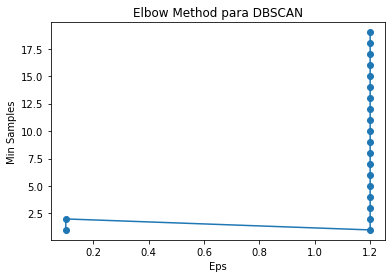

In [43]:
# Plote os resultados
fig, ax = plt.subplots()
ax.plot(scores_array[:, 0], scores_array[:, 1], marker='o', linestyle='-')

ax.set_xlabel('Eps')
ax.set_ylabel('Min Samples')
ax.set_title('Elbow Method para DBSCAN')

plt.show()

In [44]:
''' O ponto ideal é onde ocorre uma distorção onde (inertia) começa a diminuir mais lentamente "Que forma um cotovelo" no gráfico, quando isso não ocorre, busca-se os valres de (eps e min_samples) que quando aplicados ao modelo faça com que os CLUSTERS não variem mais, ou seja, o algoritmo convergiu para uma solução estável'''

' O ponto ideal é onde ocorre uma distorção onde (inertia) começa a diminuir mais lentamente "Que forma um cotovelo" no gráfico, quando isso não ocorre, busca-se os valres de (eps e min_samples) que quando aplicados ao modelo faça com que os CLUSTERS não variem mais, ou seja, o algoritmo convergiu para uma solução estável'

# 2.0 Aplicação do algoritimo de agrupamento DBSCAN

In [45]:
# Importanod bibliotecas necessárias 
from sklearn.cluster import DBSCAN

In [46]:
# Aplicando o DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples= 5)
df_normalized['cluster'] = dbscan.fit_predict(X)

In [61]:
# Visualizando os clusters
print(df_normalized['cluster'].value_counts())

0    56
1    17
Name: cluster, dtype: int64


In [48]:
df_normalized[df_normalized.cluster==1]

,latitude,longitude,id_veiculo,momento,geometry,deltaT,velocidade,geometry_anterior,distancia,distancia_acumulada,cluster,cluster_escala_original
60,-3.735728,-38.564770,32726.0,1.521022,POINT (-38.56476974487305 -3.7357280254364014),30.0,0.131293,POINT (-38.5663 -3.736013),171.675420,-1.447621,1,-1
61,-3.735643,-38.564415,32726.0,1.549310,POINT (-38.564414978027344 -3.735642910003662),30.0,-0.817672,POINT (-38.56476974487305 -3.7357280254364014),40.074255,-1.395328,1,-1
62,-3.735643,-38.564415,32726.0,1.577599,POINT (-38.564414978027344 -3.735642910003662),30.0,-1.095627,POINT (-38.564414978027344 -3.735642910003662),0.000000,-1.395328,1,-1
63,-3.735643,-38.564415,32726.0,1.605887,POINT (-38.564414978027344 -3.735642910003662),30.0,-1.095627,POINT (-38.564414978027344 -3.735642910003662),0.000000,-1.395328,1,-1
64,-3.735570,-38.563869,32726.0,1.634176,POINT (-38.56386947631836 -3.735569953918457),30.0,-0.673311,POINT (-38.564414978027344 -3.735642910003662),60.887527,-1.315876,1,-1
65,-3.734871,-38.560379,32726.0,1.662464,POINT (-38.56037902832031 -3.7348709106445312),30.0,1.624848,POINT (-38.56386947631836 -3.735569953918457),392.225652,-0.804064,1,-1
66,-3.734361,-38.557899,32726.0,1.690753,POINT (-38.557899475097656 -3.734360933303833),30.0,0.838226,POINT (-38.56037902832031 -3.7348709106445312),278.814056,-0.440242,1,-1
67,-3.733653,-38.554787,32726.0,1.719042,POINT (-38.554786682128906 -3.7336530685424805),30.0,1.338959,POINT (-38.557899475097656 -3.734360933303833),351.007413,0.017785,1,-1
68,-3.733548,-38.554245,32726.0,1.758646,POINT (-38.55424499511719 -3.7335479259490967),42.0,-0.794280,POINT (-38.554786682128906 -3.7336530685424805),60.825483,0.097156,1,-1
69,-3.733524,-38.554070,32726.0,1.786934,POINT (-38.55406951904297 -3.7335240840911865),30.0,-0.959753,POINT (-38.55424499511719 -3.7335479259490967),19.589621,0.122718,1,-1


In [49]:
'''Df4 identificado como sendo de um grupo diferente dos demais com a calibração dos parametros do modelo e levando em consideração: velocidade, momento e distancia_acumulada'''

'Df4 identificado como sendo de um grupo diferente dos demais com a calibração dos parametros do modelo e levando em consideração: velocidade, momento e distancia_acumulada'

In [50]:
# Clusters (1)
df4

,latitude,longitude,id_veiculo,momento,geometry,deltaT,velocidade,geometry_anterior,distancia,distancia_acumulada
0,-3.736013,-38.566300,NaN,2018-11-01 00:00:00,POINT (-38.5663 -3.736013),NaN,NaN,NaN,NaN,NaN
1,-3.735728,-38.564770,32726.0,2018-11-01 09:39:39,POINT (-38.56476974487305 -3.7357280254364014),30.0,5.896389,POINT (-38.5663 -3.736013),171.675420,171.675420
2,-3.735643,-38.564415,32726.0,2018-11-01 09:40:09,POINT (-38.564414978027344 -3.735642910003662),30.0,1.335808,POINT (-38.56476974487305 -3.7357280254364014),40.074255,211.749674
3,-3.735643,-38.564415,32726.0,2018-11-01 09:40:39,POINT (-38.564414978027344 -3.735642910003662),30.0,0.000000,POINT (-38.564414978027344 -3.735642910003662),0.000000,211.749674
4,-3.735643,-38.564415,32726.0,2018-11-01 09:41:09,POINT (-38.564414978027344 -3.735642910003662),30.0,0.000000,POINT (-38.564414978027344 -3.735642910003662),0.000000,211.749674
5,-3.735570,-38.563869,32726.0,2018-11-01 09:41:39,POINT (-38.56386947631836 -3.735569953918457),30.0,2.029584,POINT (-38.564414978027344 -3.735642910003662),60.887527,272.637202
6,-3.734871,-38.560379,32726.0,2018-11-01 09:42:09,POINT (-38.56037902832031 -3.7348709106445312),30.0,13.074188,POINT (-38.56386947631836 -3.735569953918457),392.225652,664.862854
7,-3.734361,-38.557899,32726.0,2018-11-01 09:42:39,POINT (-38.557899475097656 -3.734360933303833),30.0,9.293802,POINT (-38.56037902832031 -3.7348709106445312),278.814056,943.676910
8,-3.733653,-38.554787,32726.0,2018-11-01 09:43:09,POINT (-38.554786682128906 -3.7336530685424805),30.0,11.700247,POINT (-38.557899475097656 -3.734360933303833),351.007413,1294.684323
9,-3.733548,-38.554245,32726.0,2018-11-01 09:43:51,POINT (-38.55424499511719 -3.7335479259490967),42.0,1.448226,POINT (-38.554786682128906 -3.7336530685424805),60.825483,1355.509806


## 2.1 Visualização dos clusters identificados

In [51]:
# Dados dos clusters
import seaborn as sns

labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

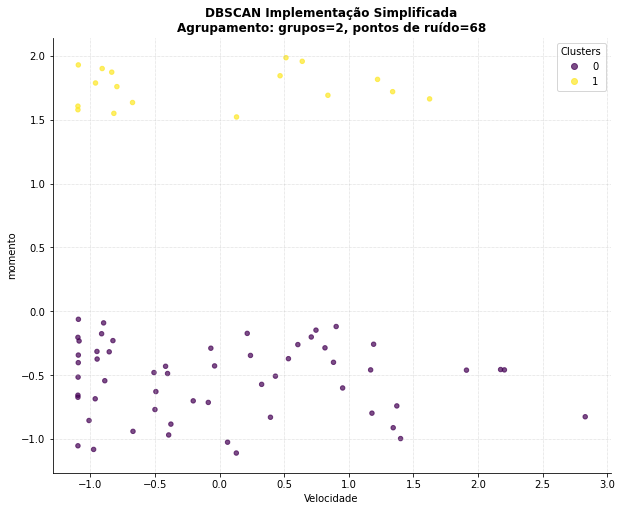

In [63]:
# Visualização do resultado do agrupamento
plt.figure(figsize=(10, 8))
plt.grid(color='0.7', linestyle=':', linewidth=0.5)

# Plotando a dispersão com cores para diferenciar os grupos
# Neste gráfico usamos os grupos previstos para definir a cor dos grupos
scatter = plt.scatter(X['velocidade'], X['momento'], c=df_normalized['cluster'], s=20, cmap='viridis', alpha=0.7)

# Adicionando a legenda
legend_labels = list(set(df_normalized['cluster']))
legend_labels.sort()
plt.legend(handles=scatter.legend_elements()[0], title="Clusters", labels=legend_labels)

# Configurações visuais adicionais
plt.title(f'DBSCAN Implementação Simplificada\nAgrupamento: grupos={n_clusters_}, pontos de ruído={n_noise_}',
          fontweight='bold')
plt.xlabel('Velocidade')
plt.ylabel('momento')
sns.despine()

# Mostrando o gráfico
plt.show()

# Salvando figura (caso necessário)
# plt.savefig('reultado_clusters.png')

# -----------------------------------------------------------------------------------------------